# Fermion back-end workflow demonstration

In cold atoms, we do not necessarily work with qubits. As an example, we implemented here the operation on a tweezer array as it is implemented in Heidelberg University. In this notebook we present the communication with our API. The communication with the backend happens through the four url

1. '.../shots/get_config/' 
2. '.../shots/post_job/'
3. '.../shots/get_job_status/'
4. '.../shots/get_job_result/'

## Preparation for local deployment

Some first things that you have to do:

- Apply any migrations to your local server `python manage.py migrate --settings main.local_settings`
- Start the server in a tab as `python manage.py runserver --settings main.local_settings`
- You created an account and saved this in the local `credentials.py` file

# get config

Getting the description of the simulator/backend as a json file

* user login  at '.../get_config'
* json file with simulator/backend description 

In [1]:
import requests
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

This imports the `credentials.py` file you received from us.

In [2]:
from credentials import username, password

In [3]:
url_prefix = 'http://localhost:8000/api/v1/fermions/'

In [4]:
url= url_prefix + "get_config"
pprint(url)
r = requests.get(url,params={'username': username,'password':password})
r_dict  = json.loads(r.text)
pprint(r_dict)

'http://localhost:8000/api/v1/fermions/get_config'
{'backend_name': 'alqor_fermionic_tweezer_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['fhop', 'fint', 'fphase'],
 'cold_atom_type': 'fermion',
 'conditional': False,
 'coupling_map': 'linear',
 'description': 'simulator of a fermionic tweezer hardware. The even wires '
                'denote the occupations of the spin-up fermions and the odd '
                'wires denote the spin-down fermions',
 'display_name': 'fermions',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0, 1, 2, 3],
                             [2, 3, 4, 5],
                             [4, 5, 6, 7],
                             [0, 1, 2, 3, 4, 5, 6, 7]],
            'description': 'hopping of atoms to neighboring tweezers',
            'name': 'fhop',
            'parameters': ['j_i'],
            'qasm_def': '{}'},
           {'coupling_map': [[0, 1, 2, 3, 4, 5, 6, 7]],
            'description': 'on-site interaction of atoms of op

# The fermionic tweezer backend

It implements four optical lattice sites with possibility of spin up and down. The first four wires are the spin up and the next four wires are the spin down.

 We have implemented:
 
 - `load` which adds a Fermion to the wire.
 - `hop` which lets Fermions hop.
 - `int` which describes interactions between fermions.
 - `phase` which is the chemical potential on the gate.
 - `measure` which reads out the occupation.

# Load gate

We will have to load fermions into the tweezer. Let us start out with that.

In [5]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('load', [7], []),
        ('load', [2], []),
        ('load', [0], []),
        ('measure', [0], []),
        ('measure', [2], []),
        ('measure', [6], []),
        ('measure', [7], []),
        ],
        'num_wires': 8,
        'shots': 4,
        "wire_order": "interleaved",
    },
}

In [6]:
url= url_prefix + "post_job" 

pprint(url)
job_response = requests.post(url, json={'job':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.json())

'http://localhost:8000/api/v1/fermions/post_job'
{'job_id': '20230301_092908-fermions-freddy-d68a6', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


test the job status

In [7]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status" 

status_response = requests.get(url, params={'job_id': job_id,'username': username,'password':password})

print(status_response.text)

{"job_id": "20230301_092908-fermions-freddy-d68a6", "status": "INITIALIZING", "detail": "Got your json.", "error_message": "None"}


job result

In [8]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result" 

result_response = requests.get(url, params={'job_id': job_id,'username': username,'password':password})

print(result_response.text)

{"backend_name": "alqor_fermionic_tweezer_simulator", "backend_version": "0.0.2", "job_id": "20230301_092908-fermions-freddy-d68a6", "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "experiment_0", "extra metadata": "text"}, "shots": 4, "success": true, "data": {"memory": ["1 1 0 1", "1 1 0 1", "1 1 0 1", "1 1 0 1"]}}], "experiments": [{"experiment_0": {"instructions": [["load", [7], []], ["load", [2], []], ["load", [0], []], ["measure", [0], []], ["measure", [2], []], ["measure", [6], []], ["measure", [7], []]], "num_wires": 8, "shots": 4, "wire_order": "interleaved"}}]}


# Hopping

we also need to make sure that hopping works. for that we load two fermions on the first lattice site and then let them hop.

In [27]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,np.pi,n_phases) #array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
            'instructions': [
                ('load', [0], []),
                ('load', [1], []),
                ('fhop', [0, 1, 2, 3], [phases[ii]]),
                ('measure', [0], []),
                ('measure', [1], []),
                ('measure', [2], []),
                ('measure', [3], []),
            ],
            'num_wires': 8,
            'shots': 9,
        "wire_order": "interleaved",
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
                                   ('measure', [3], [])],
                  'num_wires': 8,
                  'shots': 9,
                  'wire_order': 'interleaved'},
 'experiment_1': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('fhop', [0, 1, 2, 3], [0.3141592653589793]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
                                   ('measure', [3], [])],
                  'num_wires': 8,
                  'shots': 9,
   

In [28]:
url= url_prefix + "post_job" 

pprint(url)
job_response = requests.post(url, json={'job':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.json())

'http://localhost:8000/api/v1/fermions/post_job'
{'job_id': '20230301_163132-fermions-freddy-d3626', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [29]:
url= url_prefix + "get_job_status" 

status_response = requests.get(url, params={'job_id': job_id,'username': username,'password':password})

pprint(status_response.json())

{'detail': 'Got your json.',
 'error_message': 'None',
 'job_id': '20230301_163132-fermions-freddy-d3626',
 'status': 'INITIALIZING'}


In [36]:
url= url_prefix + "get_job_result" 

result_response = requests.get(url, params={'job_id': job_id,'username': username,'password':password})

results_dict  = result_response.json()
pprint(results_dict)

{'backend_name': 'alqor_fermionic_tweezer_simulator',
 'backend_version': '0.0.2',
 'experiments': [{'experiment_0': {'instructions': [['load', [0], []],
                                                    ['load', [1], []],
                                                    ['fhop',
                                                     [0, 1, 2, 3],
                                                     [0.0]],
                                                    ['measure', [0], []],
                                                    ['measure', [1], []],
                                                    ['measure', [2], []],
                                                    ['measure', [3], []]],
                                   'num_wires': 8,
                                   'shots': 9,
                                   'wire_order': 'interleaved'}},
                 {'experiment_1': {'instructions': [['load', [0], []],
                                                    ['

and make the results pretty

In [37]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

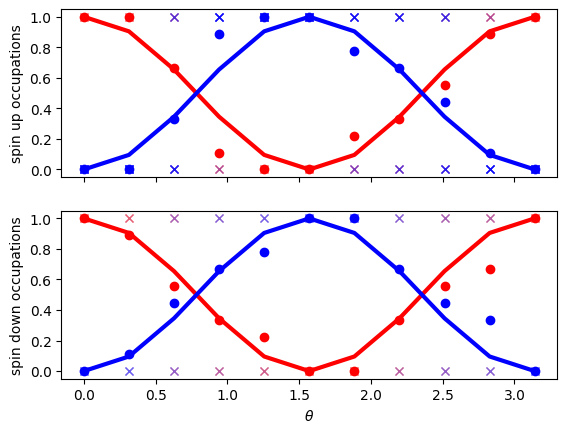

In [38]:
n0s = measurements[:,:,0];
n1s = measurements[:,:,1];
n2s = measurements[:,:,2];
n3s = measurements[:,:,3];
f, (ax1,ax2) = plt.subplots(2,1, sharex = True)
ax1.plot(phases, n0s, 'rx', alpha = 0.1)
ax1.plot(phases, n0s.mean(axis=1), 'ro')
#ax1.plot(phases, n0s, 'ro', alpha = 0.3)
ax1.plot(phases, (1+np.cos(2*phases))/2, 'r-', lw = 3)
ax1.plot(phases, n2s, 'bx', alpha = 0.3)
ax1.plot(phases, n2s.mean(axis=1), 'bo')
ax1.plot(phases, 1-(1+np.cos(2*phases))/2, 'b-', lw = 3)

ax1.set_ylabel(r'spin up occupations')

ax2.plot(phases, n1s, 'rx', alpha = 0.1)
ax2.plot(phases, n1s.mean(axis=1), 'ro')
ax2.plot(phases, (1+np.cos(2*phases))/2, 'r-', lw = 3)
ax2.plot(phases, n3s, 'bx', alpha = 0.1)
ax2.plot(phases, n3s.mean(axis=1), 'bo')
ax2.plot(phases, 1-(1+np.cos(2*phases))/2, 'b-', lw = 3)

ax2.set_ylabel('spin down occupations')

ax2.set_xlabel('$\\theta$');

# Interactions

In [ ]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('load', [0], []),
        ('load', [1], []),
        ('hop', [0, 1, 2, 3], [np.pi/4]),
        ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0]),
        ('hop', [0, 1, 2, 3], [np.pi/4]),
        ('measure', [0], []),
        ('measure', [1], []),
        ('measure', [2], []),
        ('measure', [3], []),
        ],
        'num_wires': 8,
        'shots': 4
    },
}

In [ ]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

In [ ]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

In [ ]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

## Interaction Ramsey 

where do the interactions show up in the dynamics ?

In [ ]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,np.pi,n_phases) #array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
            'instructions': [
                ('load', [0], []),
                ('load', [1], []),
                ('hop', [0, 1, 2, 3], [np.pi/4]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]]),
                ('hop', [0, 1, 2, 3], [np.pi/4]),
                ('measure', [0], []),
                ('measure', [1], []),
                ('measure', [2], []),
                ('measure', [3], []),
            ],
            'num_wires': 8,
            'shots': 9
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

In [ ]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
pprint(job_response.text)

In [ ]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
res_dict = json.loads(result_response.text)
#pprint(res_dict)

In [ ]:
measurements = []
for res in res_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

In [ ]:
n0s = measurements[:,:,0];
n1s = measurements[:,:,1];
n4s = measurements[:,:,2];
n5s = measurements[:,:,3];
f, (ax1,ax2) = plt.subplots(2,1, sharex = True)
ax1.plot(phases, n0s, 'ro', alpha = 0.1)
ax1.plot(phases, n0s.mean(axis=1), 'ro')
#ax1.plot(phases, (1+np.cos(2*phases))/2, 'r-', lw = 3)
ax1.plot(phases, n1s, 'bo', alpha = 0.1)
ax1.plot(phases, n1s.mean(axis=1), 'bo')
#ax1.plot(phases, 1-(1+np.cos(2*phases))/2, 'b-', lw = 3)

ax1.set_ylabel(r'spin up occupations')

ax2.plot(phases, n4s, 'ro', alpha = 0.3)
ax2.plot(phases, (1+np.cos(2*phases))/2, 'r-', lw = 3)
ax2.plot(phases, n5s, 'bo', alpha = 0.3)
ax2.plot(phases, 1-(1+np.cos(2*phases))/2, 'b-', lw = 3)

ax2.set_ylabel('spin down occupations')

ax2.set_xlabel('$\\theta$');

## Interaction a la Selim

In [26]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,np.pi,n_phases) #array of phases
Ntrott = 5;
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
            'instructions': [
                ('load', [0], []),
                ('load', [1], []),
                ('hop', [0, 1, 2, 3], [phases[ii]/Ntrott]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]/Ntrott]),
                ('hop', [0, 1, 2, 3], [phases[ii]/Ntrott]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]/Ntrott]),
                ('hop', [0, 1, 2, 3], [phases[ii]/Ntrott]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]/Ntrott]),
                ('hop', [0, 1, 2, 3], [phases[ii]/Ntrott]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]/Ntrott]),
                ('hop', [0, 1, 2, 3], [phases[ii]/Ntrott]),
                ('int', [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii]/Ntrott]),
                ('measure', [0], []),
                ('measure', [1], []),
                ('measure', [2], []),
                ('measure', [3], []),
            ],
            'num_wires': 8,
            'shots': 100
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('hop', [0, 1, 2, 3], [0.0]),
                                   ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('hop', [0, 1, 2, 3], [0.0]),
                                   ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('hop', [0, 1, 2, 3], [0.0]),
                                   ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('hop', [0, 1, 2, 3], [0.0]),
                                   ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('hop', [0, 1, 2, 3], [0.0]),
                                   ('int', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
           

In [27]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
pprint(job_response.text)

'{"job_id": 245, "status": "INITIALIZING", "detail": "Got your json."}'


In [28]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
res_dict = json.loads(result_response.text)
pprint(res_dict)

{'backend_name': 'synqs_fermionic_tweezer_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 245,
 'qobj_id': None,
 'results': [{'data': {'memory': ['1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
                                  '1 1 0 0',
             

In [29]:
measurements = []
for res in res_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

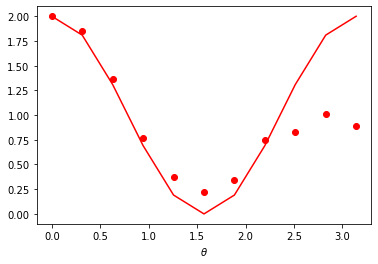

In [30]:
n0s = measurements[:,:,0];
n1s = measurements[:,:,1];
n2s = measurements[:,:,2];
n3s = measurements[:,:,3];
f, ax = plt.subplots()
ax.plot(phases, 1+np.cos(2*phases), 'r-')
#ax.plot(phases, n0s+n1s, 'ro', alpha = 0.01)
ax.plot(phases, n0s.mean(axis=1)+n1s.mean(axis=1), 'ro')
ax.set_xlabel('$\\theta$');

# Phase gate

And finish off the standard gates with the phase gate

In [791]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,2*np.pi,n_phases) #array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
            'instructions': [
                ('load', [0], []),
                ('hop', [0, 1, 2, 3], [np.pi/4]),
                ('phase', [0], [phases[ii]]),
                ('hop', [0, 1, 2, 3], [np.pi/4]),
                ('measure', [0], []),
                ('measure', [2], []),
            ],
            'num_wires': 8,
            'shots': 9
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('load', [0], []),
                                   ('hop', [0, 1, 2, 3], [0.7853981633974483]),
                                   ('phase', [0], [0.0]),
                                   ('hop', [0, 1, 2, 3], [0.7853981633974483]),
                                   ('measure', [0], []),
                                   ('measure', [2], [])],
                  'num_wires': 8,
                  'shots': 9},
 'experiment_1': {'instructions': [('load', [0], []),
                                   ('hop', [0, 1, 2, 3], [0.7853981633974483]),
                                   ('phase', [0], [0.6283185307179586]),
                                   ('hop', [0, 1, 2, 3], [0.7853981633974483]),
                                   ('measure', [0], []),
                                   ('measure', [2], [])],
                  'num_wires': 8,
                  'shots': 9},
 'experiment_10': {'instructions': [('load', [0], []),
                          

In [792]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
pprint(job_response.text)

'{"job_id": 239, "status": "INITIALIZING", "detail": "Got your json."}'


In [793]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
res_dict = json.loads(result_response.text)
pprint(res_dict)

{'backend_name': 'synqs_fermionic_tweezer_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 239,
 'qobj_id': None,
 'results': [{'data': {'memory': ['0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1']},
              'header': {'extra metadata': 'None', 'name': 'FermionTweezer'},
              'shots': 9,
              'success': True},
             {'data': {'memory': ['0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '0 1',
                                  '1 0',
                                  '0 1',
                                  '0 1',
                                 

In [794]:
measurements = []
for res in res_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

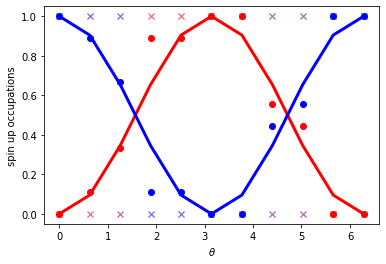

In [795]:

n0s = measurements[:,:,0];
n1s = measurements[:,:,1];

f, ax = plt.subplots()
ax.plot(phases, n0s, 'rx', alpha = 0.1)
ax.plot(phases, n0s.mean(axis=1), 'ro')
ax.plot(phases, 1-(1+np.cos(phases))/2, 'r-', lw = 3)
ax.plot(phases, n1s, 'bx', alpha = 0.1)
ax.plot(phases, n1s.mean(axis=1), 'bo')
ax.plot(phases, (1+np.cos(phases))/2, 'b-', lw = 3)

ax.set_ylabel(r'spin up occupations')
ax.set_xlabel('$\\theta$');